In [2]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib

c:\vsc\research\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.9


In [4]:
file_path = 'DB for chromophore_Sci_Data_rev02.csv'

df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.01]  # take quantum yields bigger than 0.01
print("Filtered dataset size:", len(df))
df.head()

Filtered dataset size: 12541


,Chromophore,Solvent,Quantum yield
34,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
43,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
71,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
72,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
73,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


In [5]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [6]:
import os
import torch

CACHE_FILE = "embedding_cache.pt"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return torch.load(CACHE_FILE)
    else:
        return {}  # empty cache

def save_cache(cache):
    torch.save(cache, CACHE_FILE)

In [7]:
def get_embeddings(smiles_list, batch_size=32, max_length=202):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cache = load_cache()
    all_embeddings = []


    to_compute = [s for s in smiles_list if s not in cache]

    if len(to_compute) > 0:
        print(f"Computing {len(to_compute)} new embeddings on {device}...")


        model.to(device)
        model.eval()

        with torch.no_grad():
            for i in range(0, len(to_compute), batch_size):
                batch = to_compute[i:i+batch_size]

                inputs = tokenizer(
                    batch, padding=True, truncation=True,
                    max_length=max_length, return_tensors="pt"
                ).to(device)


                outputs = model(**inputs)
                embeddings = outputs.pooler_output 


                for s, emb in zip(batch, embeddings):
                    cache[s] = emb.cpu()


        save_cache(cache)

    else:
        print("All embeddings already in cache.")


    ordered = [cache[s] for s in smiles_list]
    return torch.stack(ordered)


In [8]:
chrom_emb = get_embeddings(df["Chromophore"].tolist())
print("Chromophore embeddings shape:", chrom_emb.shape)

solv_emb = get_embeddings(df["Solvent"].tolist())
print("Solvent embeddings shape:", solv_emb.shape)

combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
print("Combined embedding shape:", combined_emb.shape)

All embeddings already in cache.
Chromophore embeddings shape: torch.Size([12541, 768])
All embeddings already in cache.
Solvent embeddings shape: torch.Size([12541, 768])
Combined embedding shape: torch.Size([12541, 1536])


In [9]:
from sklearn.preprocessing import StandardScaler

chrom_emb_scaled = torch.tensor(StandardScaler().fit_transform(chrom_emb.numpy()), dtype=torch.float32)
solv_emb_scaled = torch.tensor(StandardScaler().fit_transform(solv_emb.numpy()), dtype=torch.float32)
combined_emb = torch.cat([chrom_emb_scaled, solv_emb_scaled], dim=1)
y = torch.tensor(df["Quantum yield"].values, dtype=torch.float32).unsqueeze(1)

In [10]:
# Instead of combining before train/test split:


# Reproducible splits
RANDOM_STATE = 42

# current variables from your notebook:
# chrom_emb_scaled (torch.Tensor, [N, D])
# solv_emb_scaled  (torch.Tensor, [N, D])
# y                (torch.Tensor, [N, 1])

# 1) Split out test set (20% of full data)
chrom_trainval, chrom_test, solv_trainval, solv_test, y_trainval, y_test = train_test_split(
    chrom_emb_scaled, solv_emb_scaled, y, test_size=0.20, random_state=RANDOM_STATE
)

# 2) Split train/validation from remaining (we want val = 10% of total)
#    trainval size = 0.80 of total; to get val=0.10 total -> val fraction of trainval = 0.10/0.80 = 0.125
val_frac_of_trainval = 0.10 / 0.80  # = 0.125
chrom_train, chrom_val, solv_train, solv_val, y_train, y_val = train_test_split(
    chrom_trainval, solv_trainval, y_trainval, test_size=val_frac_of_trainval, random_state=RANDOM_STATE
)

# Check sizes
N_total = chrom_emb_scaled.shape[0]
print(f"Total samples: {N_total}")
print(f"Train samples: {len(chrom_train)} ({len(chrom_train)/N_total:.2%})")
print(f"Val   samples: {len(chrom_val)} ({len(chrom_val)/N_total:.2%})")
print(f"Test  samples: {len(chrom_test)} ({len(chrom_test)/N_total:.2%})")

# Convert to TensorDataset (they are already torch tensors)
train_ds = TensorDataset(chrom_train, solv_train, y_train)
val_ds   = TensorDataset(chrom_val,   solv_val,   y_val)
test_ds  = TensorDataset(chrom_test,  solv_test,  y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Total samples: 12541
Train samples: 8778 (69.99%)
Val   samples: 1254 (10.00%)
Test  samples: 2509 (20.01%)


In [11]:
# quick batch shapes
for name, loader in (("train", train_loader), ("val", val_loader), ("test", test_loader)):
    xb_ch, xb_sv, yb = next(iter(loader))
    print(f"{name} batch shapes -> chrom: {xb_ch.shape}, solv: {xb_sv.shape}, y: {yb.shape}")

train batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])
val batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])
test batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])


In [12]:
#Transformer

In [13]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        chrom = self.embedding(chrom).unsqueeze(1)
        solv = self.embedding(solv).unsqueeze(1)
        x = torch.cat([chrom, solv], dim=1)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.regressor(x)
    
    def predict(self, chrom, solv, device='cpu'):
        """Predict on numpy arrays or tensors (returns numpy)"""
        self.eval()
        with torch.no_grad():
            if not isinstance(chrom, torch.Tensor):
                chrom = torch.tensor(chrom, dtype=torch.float32)
            if not isinstance(solv, torch.Tensor):
                solv = torch.tensor(solv, dtype=torch.float32)
            chrom = chrom.to(device)
            solv = solv.to(device)
            pred = self.forward(chrom, solv)
            return pred.cpu().numpy()


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb_scaled.shape[1]
transformer_model = TransformerRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

epochs = 100
train_losses = []

for epoch in range(epochs):
    transformer_model.train()
    total_loss = 0
    
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        
        # Forward pass with separate chromophore and solvent
        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f}")

print("Training complete!")

Using device: cuda
Epoch 1/100 | Training Loss: 0.0791
Epoch 10/100 | Training Loss: 0.0253
Epoch 20/100 | Training Loss: 0.0140
Epoch 30/100 | Training Loss: 0.0094
Epoch 40/100 | Training Loss: 0.0074
Epoch 50/100 | Training Loss: 0.0062
Epoch 60/100 | Training Loss: 0.0053
Epoch 70/100 | Training Loss: 0.0045
Epoch 80/100 | Training Loss: 0.0040
Epoch 90/100 | Training Loss: 0.0036
Epoch 100/100 | Training Loss: 0.0033
Training complete!


Device: cuda
Loaded checkpoint: models/transformer_best.pth

=== Test Set Evaluation ===
Samples: 2509
R²   : 0.6041
MAE  : 0.1301
RMSE : 0.1887


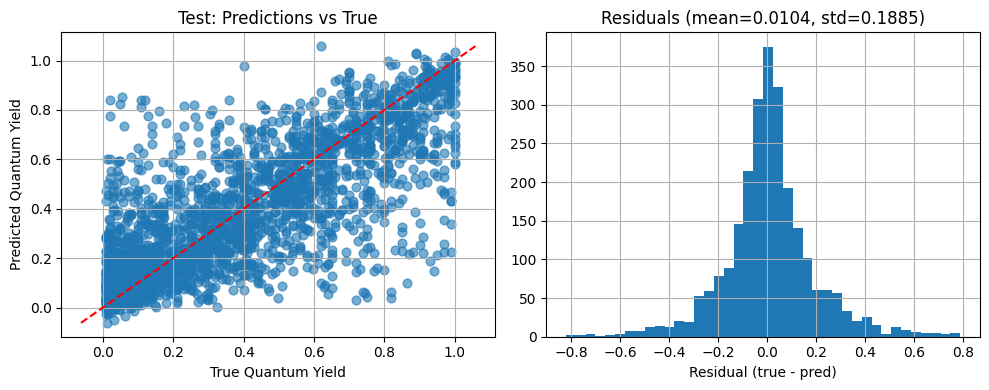

In [16]:
import os
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# instantiate model the same way used during training
input_dim = chrom_emb_scaled.shape[1]
model = TransformerRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

# If you saved the best checkpoint as "models/transformer_best.pth", load it:
ckpt_path = "models/transformer_best.pth"
if os.path.exists(ckpt_path):
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print(f"Loaded checkpoint: {ckpt_path}")
else:
    print("No checkpoint found; using current model weights (untrained or as-is).")

model.eval()
y_true_list, y_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in test_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = model(chrom_batch, solv_batch)  # shape [B,1]
        y_true_list.append(yb.cpu())
        y_pred_list.append(pred.cpu())

y_true = torch.cat(y_true_list).squeeze().numpy()
y_pred = torch.cat(y_pred_list).squeeze().numpy()

r2  = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse= np.sqrt(mean_squared_error(y_true, y_pred))

print("\n=== Test Set Evaluation ===")
print(f"Samples: {len(y_true)}")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

# Plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_true, y_pred, alpha=0.6, s=40)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Test: Predictions vs True")
plt.grid(True)

plt.subplot(1,2,2)
residuals = y_true - y_pred
plt.hist(residuals, bins=40)
plt.xlabel("Residual (true - pred)")
plt.title(f"Residuals (mean={residuals.mean():.4f}, std={residuals.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
class CrossAttentionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        # Cross-attention layers
        self.cross_attn_layers = nn.ModuleList([
            nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        
        # Layer norms
        self.norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers * 2)
        ])
        
        # Feed-forward networks
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim * 4),
                nn.ReLU(),
                nn.Linear(hidden_dim * 4, hidden_dim)
            )
            for _ in range(num_layers)
        ])
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        # Embed chromophore and solvent
        chrom = self.embedding(chrom).unsqueeze(1)  # [batch, 1, hidden_dim]
        solv = self.embedding(solv).unsqueeze(1)    # [batch, 1, hidden_dim]
        
        # Cross-attention layers
        for i, (attn, norm1, norm2, ffn) in enumerate(zip(
            self.cross_attn_layers, 
            self.norms[::2], 
            self.norms[1::2], 
            self.ffns
        )):
            # Chromophore attends to solvent
            attn_out, _ = attn(chrom, solv, solv)
            chrom = norm1(chrom + attn_out)
            ffn_out = ffn(chrom)
            chrom = norm2(chrom + ffn_out)
            
            # Solvent attends to chromophore
            attn_out, _ = attn(solv, chrom, chrom)
            solv = norm1(solv + attn_out)
            ffn_out = ffn(solv)
            solv = norm2(solv + ffn_out)
        
        # Concatenate and regress
        x = torch.cat([chrom, solv], dim=-1).flatten(1)
        return self.regressor(x)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb_scaled.shape[1]
transformer_model = CrossAttentionRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

epochs = 100
train_losses = []

for epoch in range(epochs):
    transformer_model.train()
    total_loss = 0
    
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        
        # Forward pass - cross-attention learns interactions
        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f}")

print("Training complete!")

Using device: cuda
Epoch 1/100 | Training Loss: 0.0758
Epoch 10/100 | Training Loss: 0.0232
Epoch 20/100 | Training Loss: 0.0120
Epoch 30/100 | Training Loss: 0.0082
Epoch 40/100 | Training Loss: 0.0062
Epoch 50/100 | Training Loss: 0.0047
Epoch 60/100 | Training Loss: 0.0041
Epoch 70/100 | Training Loss: 0.0037
Epoch 80/100 | Training Loss: 0.0034
Epoch 90/100 | Training Loss: 0.0021
Epoch 100/100 | Training Loss: 0.0019
Training complete!



=== Cross-Attention Model Evaluation ===
R² Score: 0.6219
MAE: 0.1291
RMSE: 0.1845


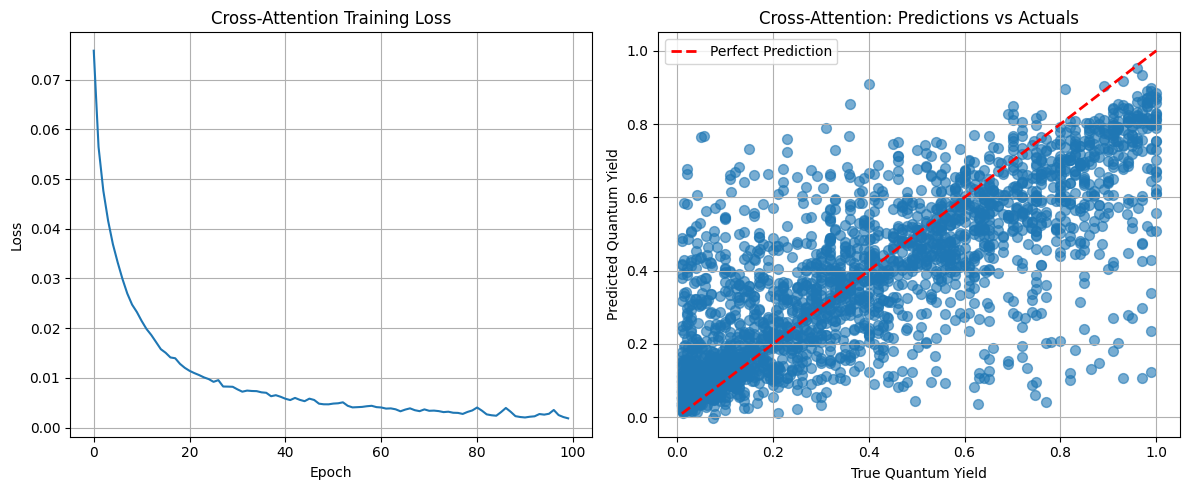


Residuals - Mean: 0.0198, Std: 0.1834


In [17]:
transformer_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in test_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        
        # Forward pass with separate chromophore and solvent
        pred = transformer_model(chrom_batch, solv_batch)
        y_true.append(yb.cpu())
        y_pred.append(pred.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\n=== Cross-Attention Model Evaluation ===")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Cross-Attention Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.6, s=50)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Cross-Attention: Predictions vs Actuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional metrics
residuals = y_true - y_pred
print(f"\nResiduals - Mean: {residuals.mean():.4f}, Std: {residuals.std():.4f}")


=== Transformer/CrossAttention Validation Results ===
Samples: 1254
R²   : 0.5956
MAE  : 0.1316
RMSE : 0.1939


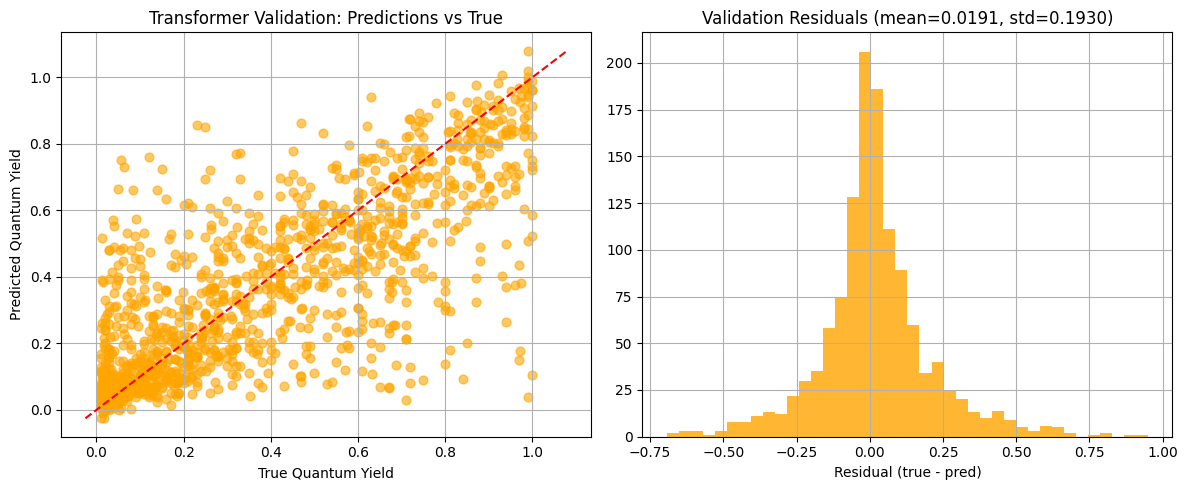

In [19]:
# Validation Set Evaluation for Transformer/CrossAttention
print("\n" + "="*50)
print("=== Transformer/CrossAttention Validation Results ===")
print("="*50)

transformer_model.eval()
y_val_true_list, y_val_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in val_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch)
        y_val_true_list.append(yb.cpu())
        y_val_pred_list.append(pred.cpu())

y_val_true = torch.cat(y_val_true_list).squeeze().numpy()
y_val_pred = torch.cat(y_val_pred_list).squeeze().numpy()

r2_val  = r2_score(y_val_true, y_val_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

print(f"Samples: {len(y_val_true)}")
print(f"R²   : {r2_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")

# Plots: validation parity and residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.6, s=40, color='orange')
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Transformer Validation: Predictions vs True")
plt.grid(True)

plt.subplot(1, 2, 2)
residuals_val = y_val_true - y_val_pred
plt.hist(residuals_val, bins=40, alpha=0.8, color='orange')
plt.xlabel("Residual (true - pred)")
plt.title(f"Validation Residuals (mean={residuals_val.mean():.4f}, std={residuals_val.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()


In [43]:

X = combined_emb.numpy()
y = y.squeeze(1).numpy()

data_dmatrix = xgb.DMatrix(data=X,label=y)

In [44]:

# Split into train/val/test (70% train, 10% val, 20% test)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split trainval into train and val (10/70 = ~14.3% of trainval)
val_frac = 0.10 / 0.80
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_frac, random_state=42
)

print(f"Train: {len(X_train)} samples ({len(X_train)/len(X):.2%})")
print(f"Val:   {len(X_val)} samples ({len(X_val)/len(X):.2%})")
print(f"Test:  {len(X_test)} samples ({len(X_test)/len(X):.2%})")


In [45]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [47]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

KeyboardInterrupt: 

In [48]:
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


=== XGBoost Test Set Results ===
Samples: 2509
R²   : 0.6223
MAE  : 0.1325
RMSE : 0.1844
Predictions saved to `models/xgb_predictions.csv`
Model saved to `models/xgb_res3.pkl`


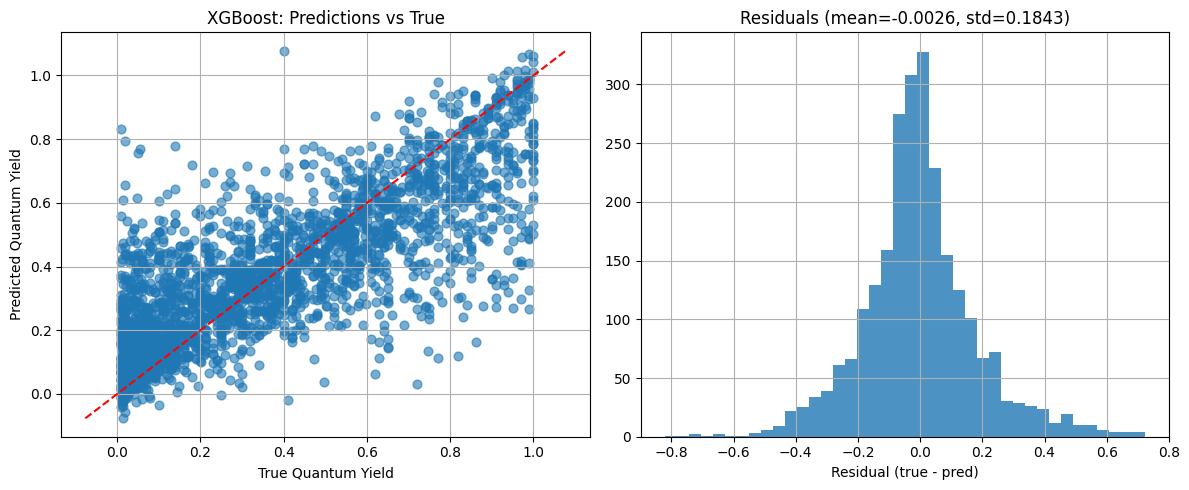

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import os

# Predict
y_pred = model.predict(X_test)

# Ensure shapes are 1-D arrays
y_true = np.ravel(y_test)
y_pred = np.ravel(y_pred)

# Metrics
r2  = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("=== XGBoost Test Set Results ===")
print(f"Samples: {len(y_true)}")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

# Save predictions (optional)
os.makedirs("models", exist_ok=True)
pred_df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
pred_df.to_csv("models/xgb_predictions.csv", index=False)
print("Predictions saved to `models/xgb_predictions.csv`")

# Save model (optional)
joblib.dump(model, "models/xgb_res3.pkl")
print("Model saved to `models/xgb_res3.pkl`")

# Plots: parity and residuals
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_true, y_pred, alpha=0.6, s=40)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("XGBoost: Predictions vs True")
plt.grid(True)

plt.subplot(1,2,2)
residuals = y_true - y_pred
plt.hist(residuals, bins=40, alpha=0.8)
plt.xlabel("Residual (true - pred)")
plt.title(f"Residuals (mean={residuals.mean():.4f}, std={residuals.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
# Validation Set Evaluation
print("\n" + "="*50)
print("=== XGBoost Validation Set Results ===")
print("="*50)

y_val_pred = model.predict(X_val)

# Ensure shapes are 1-D arrays
y_val_true = np.ravel(y_val)
y_val_pred = np.ravel(y_val_pred)

# Metrics on validation
r2_val  = r2_score(y_val_true, y_val_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

print(f"Samples: {len(y_val_true)}")
print(f"R²   : {r2_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")

# Plots: validation parity and residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.6, s=40, color='green')
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("XGBoost Validation: Predictions vs True")
plt.grid(True)

plt.subplot(1, 2, 2)
residuals_val = y_val_true - y_val_pred
plt.hist(residuals_val, bins=40, alpha=0.8, color='green')
plt.xlabel("Residual (true - pred)")
plt.title(f"Validation Residuals (mean={residuals_val.mean():.4f}, std={residuals_val.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "="*50)
print("Train/Val/Test Comparison")
print("="*50)
comparison_df = pd.DataFrame({
    "Set": ["Validation", "Test"],
    "Samples": [len(y_val_true), len(y_true)],
    "R²": [r2_val, r2],
    "MAE": [mae_val, mae],
    "RMSE": [rmse_val, rmse]
})
print(comparison_df.to_string(index=False))


=== XGBoost Validation Set Results ===


AttributeError: 'TransformerRegressor' object has no attribute 'predict'